# EDA - Risque de credit (PD binaire)

Objectif : comprendre la qualite des donnees, la distribution de la cible, les caracteristiques principales des variables explicatives et leurs relations avec le defaut. Cette etape sert a justifier les choix de preparation et de modele.


## 1) Chargement des donnees

Pourquoi : partir d'une source unique (interim) garantit que la cible a ete recodee et que les analyses sont reproductibles sans toucher a data/raw.


In [1]:
from pathlib import Path
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def find_project_root(start: Path) -> Path:
    for path in [start] + list(start.parents):
        if (path / "src").is_dir():
            return path
    raise FileNotFoundError("Project root with 'src' not found")


root = find_project_root(Path.cwd())
os.chdir(root)
if str(root) not in sys.path:
    sys.path.append(str(root))

from src.data.load_data import read_interim_credit_csv

df = read_interim_credit_csv()
df.head()


,Comptes,Duree_credit,Historique_credit,Objet_credit,Montant_credit,Epargne,Anciennete_emploi,Taux_effort,Situation_familiale,Garanties,...,Biens,Age,Autres_credits,Statut_domicile,Nb_credits,Type_emploi,Nb_pers_charge,Telephone,Etranger,Cible
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


## 2) Vue d'ensemble et types de variables

Pourquoi : verifier la taille, les types, et detecter rapidement des anomalies de format.


In [2]:
df.shape

(1000, 21)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Comptes              1000 non-null   object
 1   Duree_credit         1000 non-null   int64 
 2   Historique_credit    1000 non-null   object
 3   Objet_credit         1000 non-null   object
 4   Montant_credit       1000 non-null   int64 
 5   Epargne              1000 non-null   object
 6   Anciennete_emploi    1000 non-null   object
 7   Taux_effort          1000 non-null   int64 
 8   Situation_familiale  1000 non-null   object
 9   Garanties            1000 non-null   object
 10  Anciennete_domicile  1000 non-null   int64 
 11  Biens                1000 non-null   object
 12  Age                  1000 non-null   int64 
 13  Autres_credits       1000 non-null   object
 14  Statut_domicile      1000 non-null   object
 15  Nb_credits           1000 non-null   int64 
 16  Type_em

In [4]:
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]
numeric_cols, categorical_cols

(['Duree_credit',
  'Montant_credit',
  'Taux_effort',
  'Anciennete_domicile',
  'Age',
  'Nb_credits',
  'Nb_pers_charge',
  'Cible'],
 ['Comptes',
  'Historique_credit',
  'Objet_credit',
  'Epargne',
  'Anciennete_emploi',
  'Situation_familiale',
  'Garanties',
  'Biens',
  'Autres_credits',
  'Statut_domicile',
  'Type_emploi',
  'Telephone',
  'Etranger'])

## 3) Qualite des donnees (valeurs manquantes, doublons)

Pourquoi : identifier les besoins de traitement (imputation, suppression, alertes).


In [5]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

Series([], dtype: int64)

In [6]:
df.duplicated().sum()

np.int64(0)

## 4) Distribution de la cible

Pourquoi : mesurer le desiquilibre de classe et fixer une reference (taux de defaut).


In [7]:
target_col = "Cible"
target_counts = df[target_col].value_counts().sort_index()
target_rates = df[target_col].value_counts(normalize=True).sort_index()
target_counts, target_rates

(Cible
 0    700
 1    300
 Name: count, dtype: int64,
 Cible
 0    0.7
 1    0.3
 Name: proportion, dtype: float64)

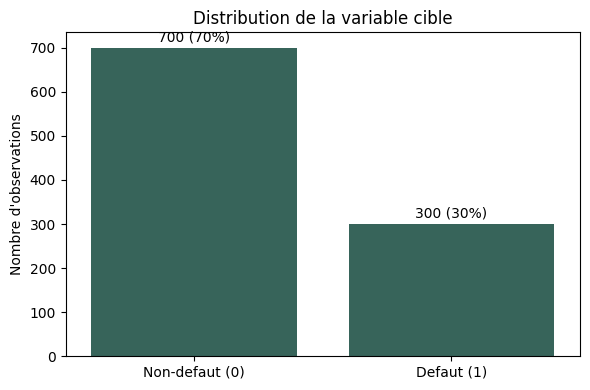

In [8]:
counts = df['Cible'].value_counts().sort_index()
rates = counts / counts.sum()
labels = ['Non-defaut (0)', 'Defaut (1)']
values = [counts.get(0, 0), counts.get(1, 0)]
percents = [rates.get(0, 0.0), rates.get(1, 0.0)]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=values, color='#2f6b5f')
plt.ylabel("Nombre d'observations")
plt.xlabel('')
plt.title('Distribution de la variable cible')
for i, (v, p) in enumerate(zip(values, percents)):
    plt.text(i, v + max(values) * 0.02, f'{v} ({p:.0%})', ha='center')
plt.tight_layout()
plt.show()


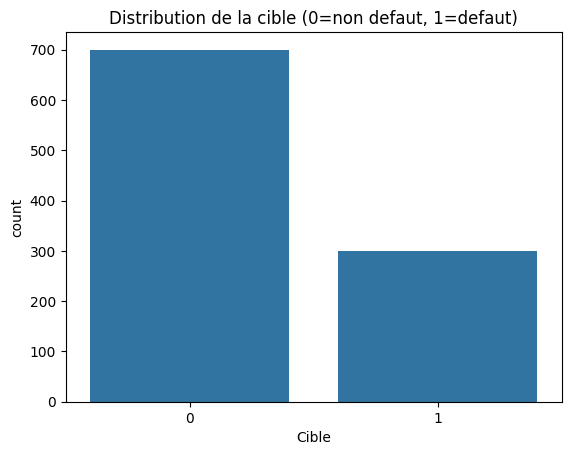

In [9]:
sns.countplot(x=target_col, data=df)
plt.title("Distribution de la cible (0=non defaut, 1=defaut)")
plt.show()

## 5) Statistiques descriptives - variables numeriques

Pourquoi : comprendre les ordres de grandeur et detecter les valeurs extremes.


In [10]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Duree_credit,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
Montant_credit,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Taux_effort,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
Anciennete_domicile,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Nb_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
Nb_pers_charge,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0
Cible,1000.0,0.300,0.458487,0.0,0.0,0.0,1.00,1.0


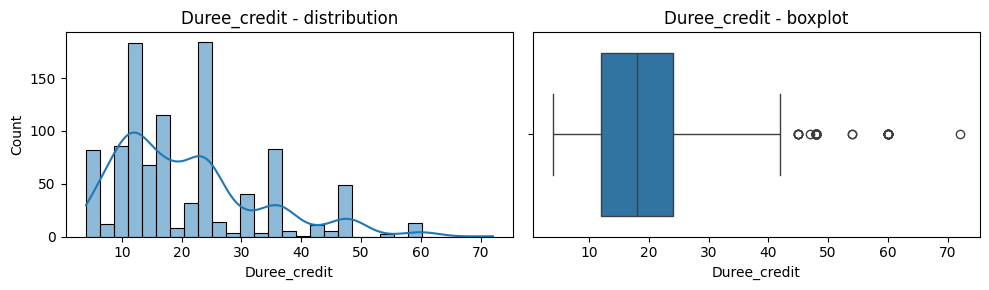

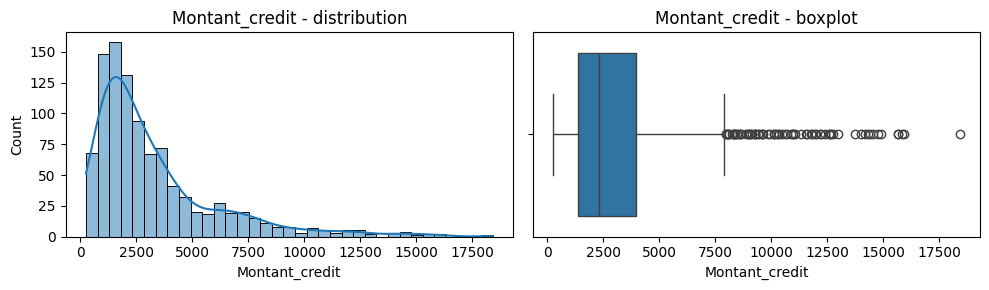

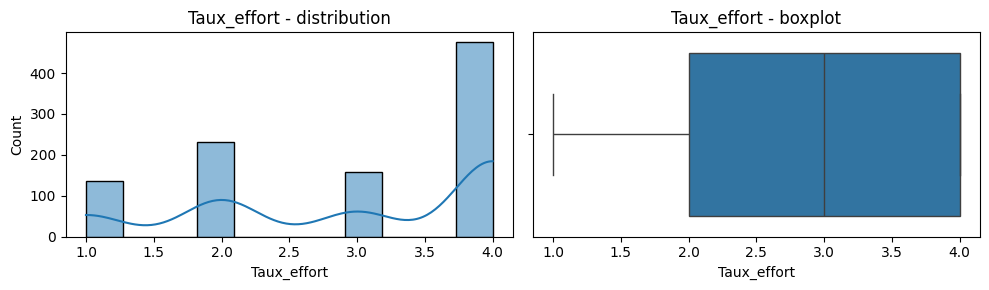

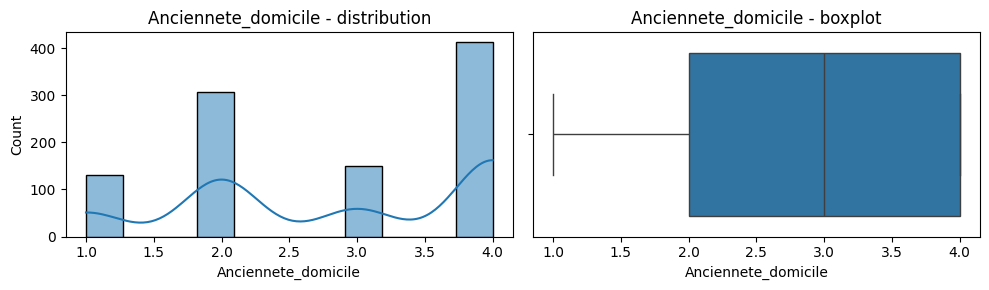

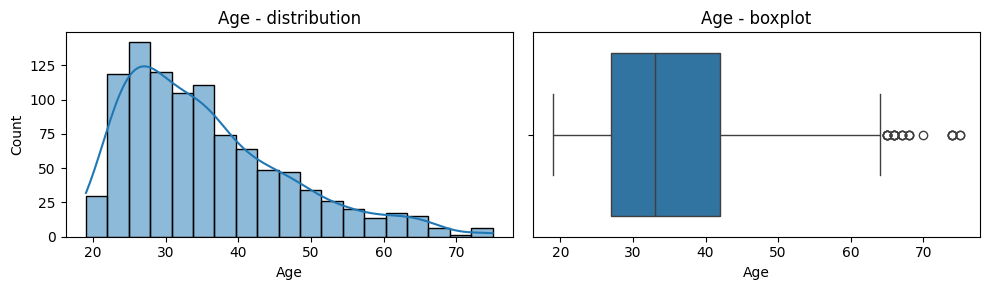

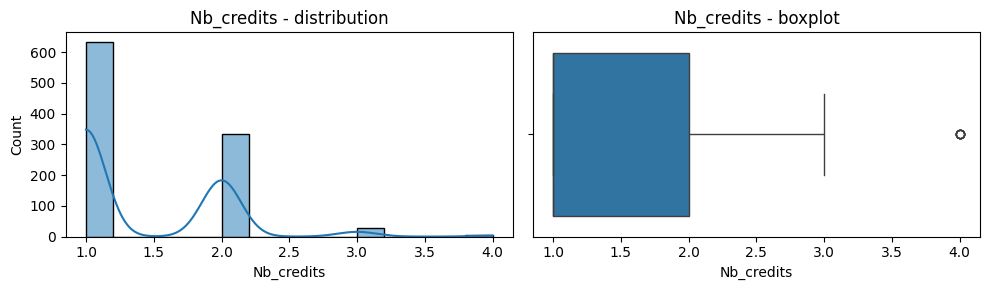

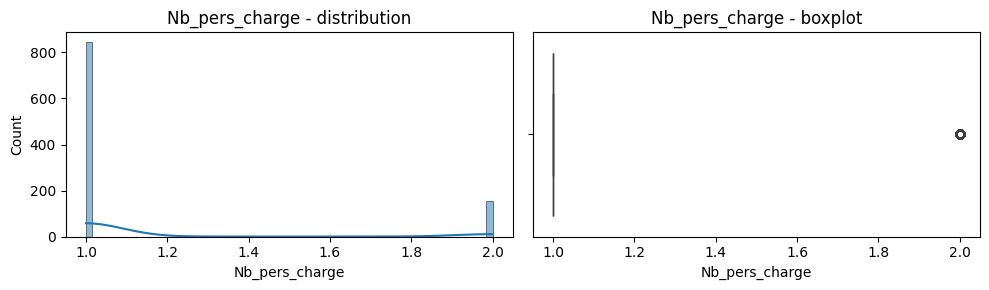

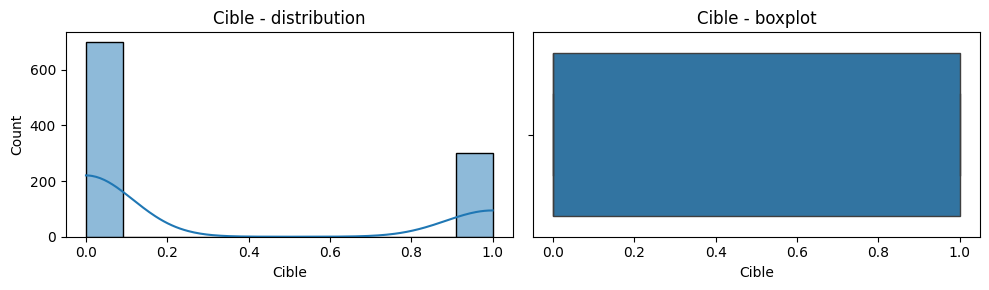

In [11]:
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"{col} - distribution")
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"{col} - boxplot")
    plt.tight_layout()
    plt.show()

## 6) Statistiques descriptives - variables categorielles

Pourquoi : identifier les modalites dominantes et les classes rares.


In [12]:
for col in categorical_cols:
    vc = df[col].value_counts(dropna=False)
    display(vc.head(10))

Comptes
A14    394
A11    274
A12    269
A13     63
Name: count, dtype: int64

Historique_credit
A32    530
A34    293
A33     88
A31     49
A30     40
Name: count, dtype: int64

Objet_credit
A43     280
A40     234
A42     181
A41     103
A49      97
A46      50
A45      22
A44      12
A410     12
A48       9
Name: count, dtype: int64

Epargne
A61    603
A65    183
A62    103
A63     63
A64     48
Name: count, dtype: int64

Anciennete_emploi
A73    339
A75    253
A74    174
A72    172
A71     62
Name: count, dtype: int64

Situation_familiale
A93    548
A92    310
A94     92
A91     50
Name: count, dtype: int64

Garanties
A101    907
A103     52
A102     41
Name: count, dtype: int64

Biens
A123    332
A121    282
A122    232
A124    154
Name: count, dtype: int64

Autres_credits
A143    814
A141    139
A142     47
Name: count, dtype: int64

Statut_domicile
A152    713
A151    179
A153    108
Name: count, dtype: int64

Type_emploi
A173    630
A172    200
A174    148
A171     22
Name: count, dtype: int64

Telephone
A191    596
A192    404
Name: count, dtype: int64

Etranger
A201    963
A202     37
Name: count, dtype: int64

## 7) Relation variables / defaut

Pourquoi : observer les liens simples avec la cible avant toute modelisation.


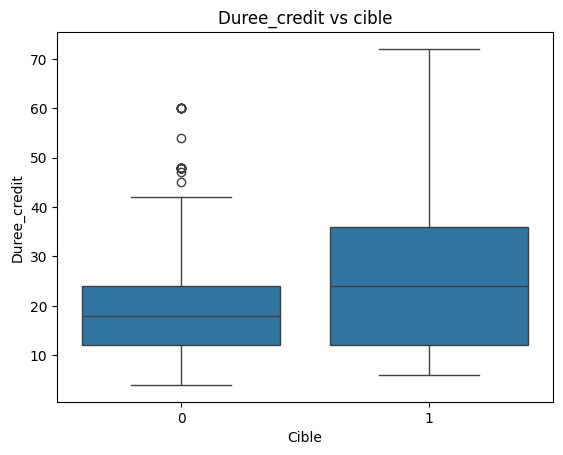

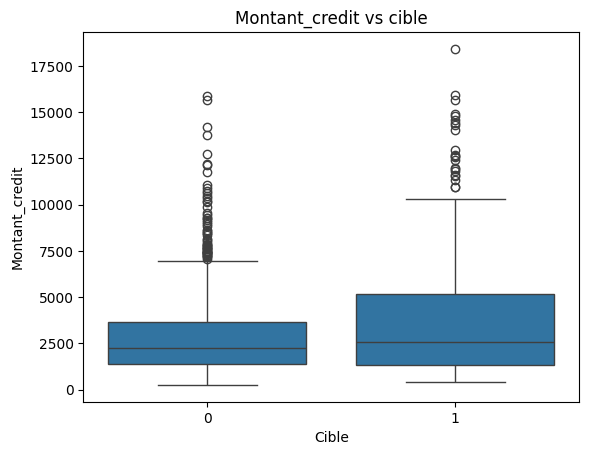

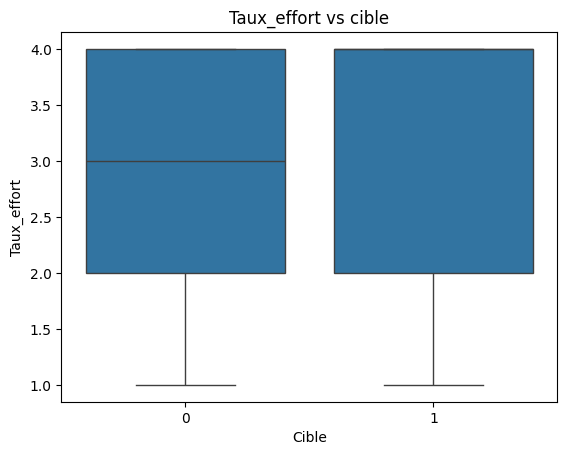

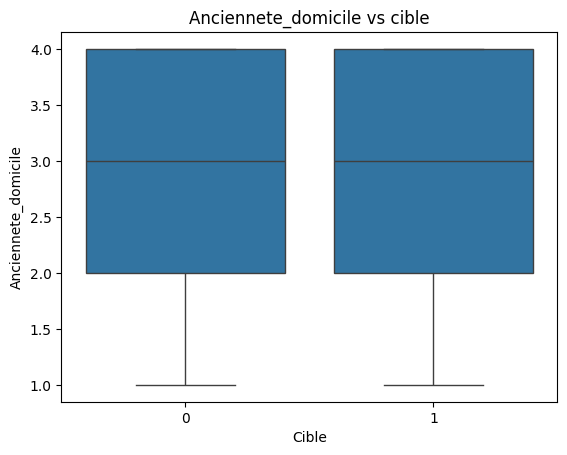

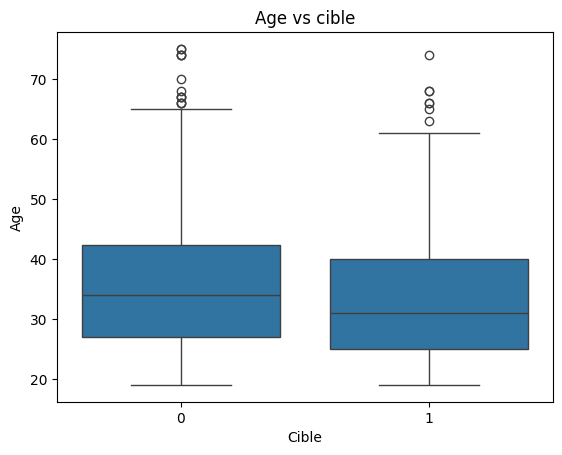

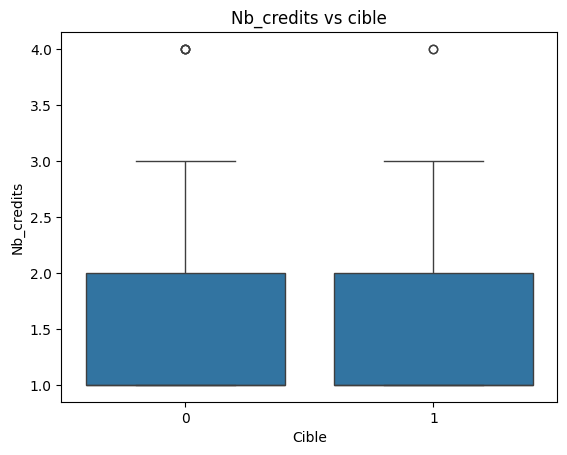

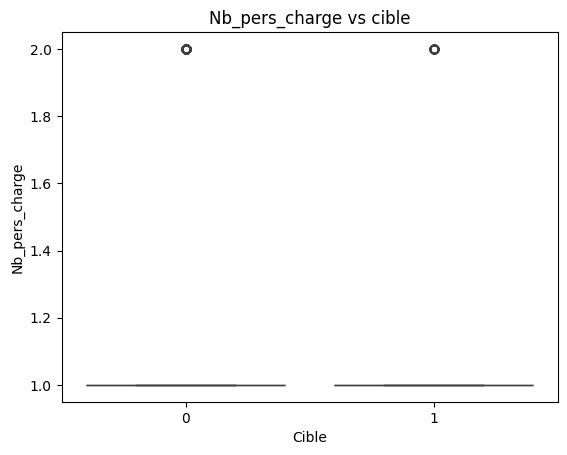

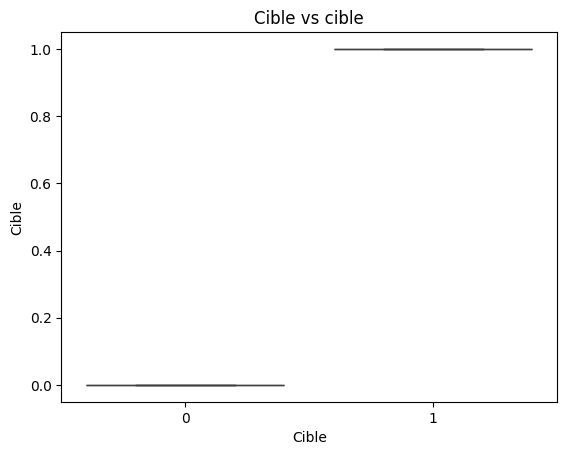

In [13]:
for col in numeric_cols:
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f"{col} vs cible")
    plt.show()

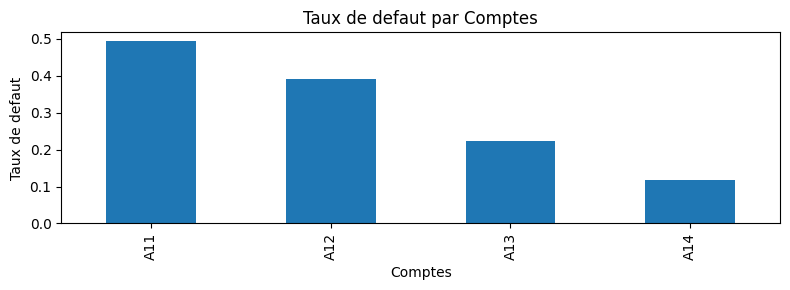

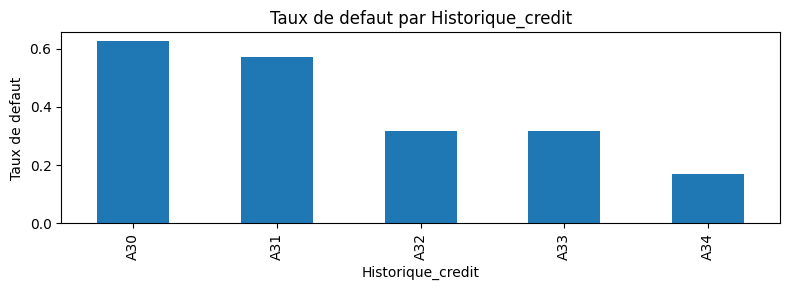

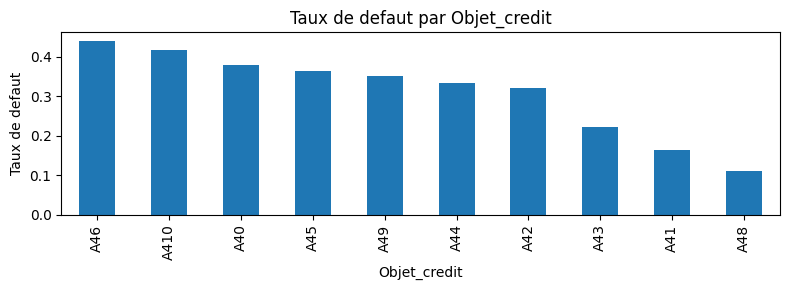

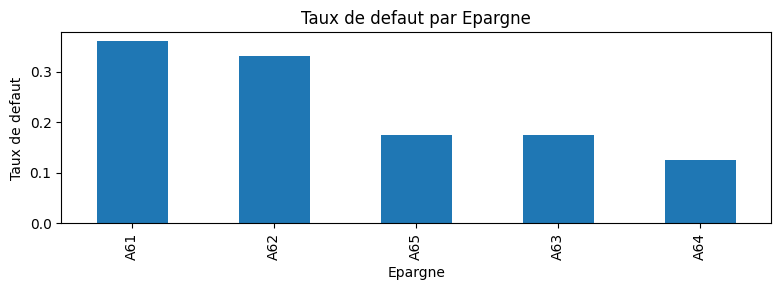

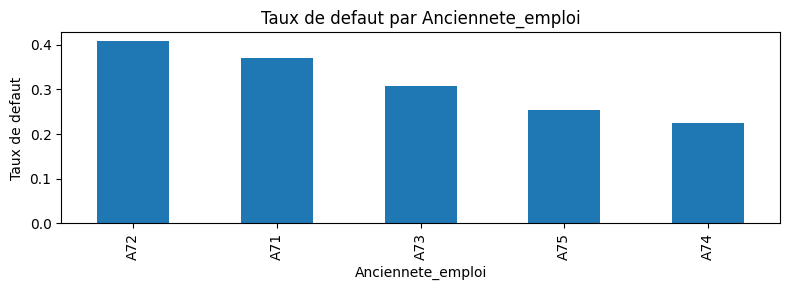

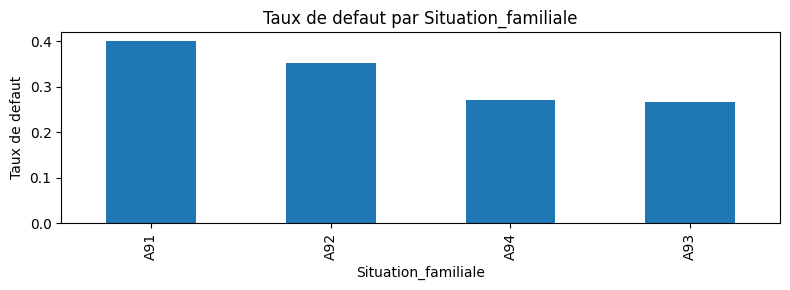

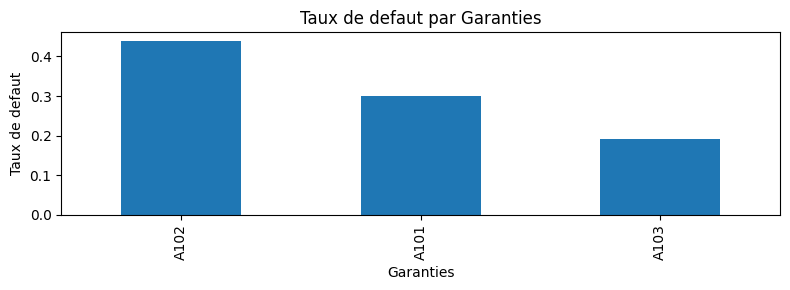

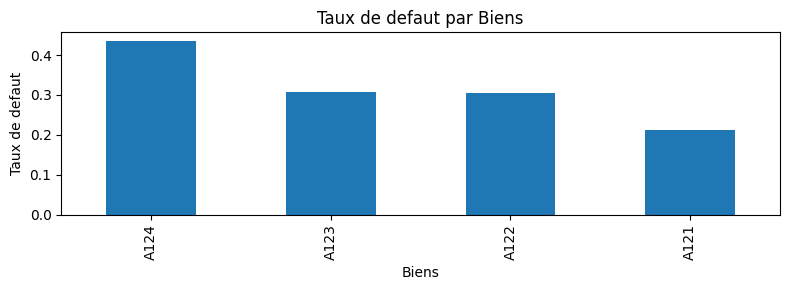

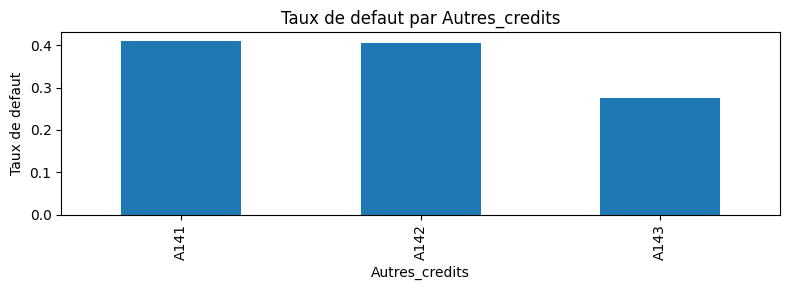

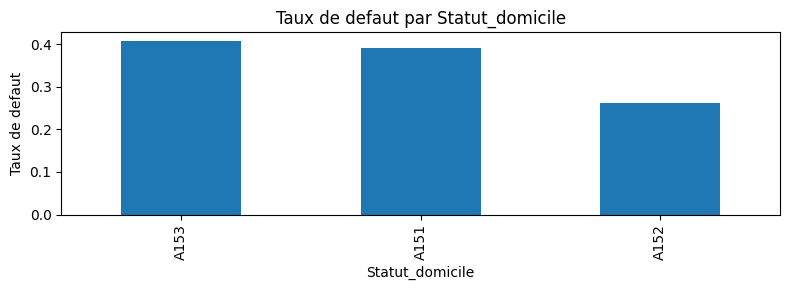

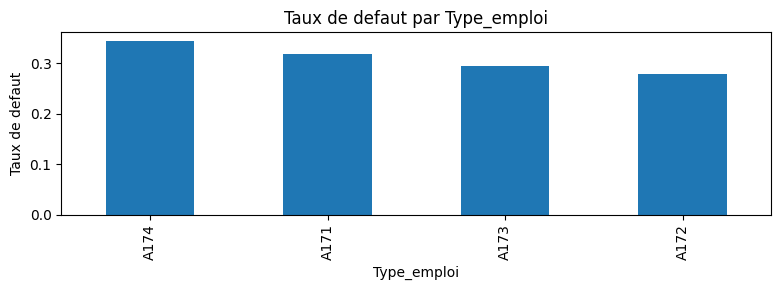

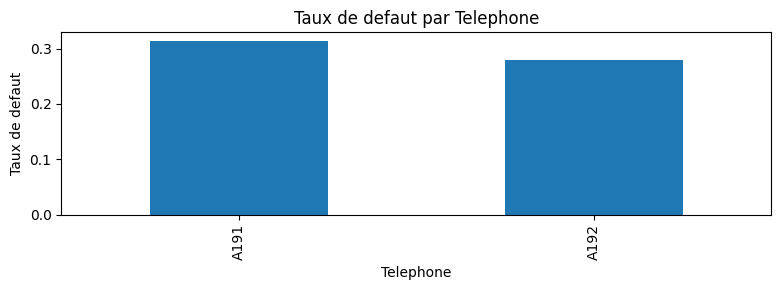

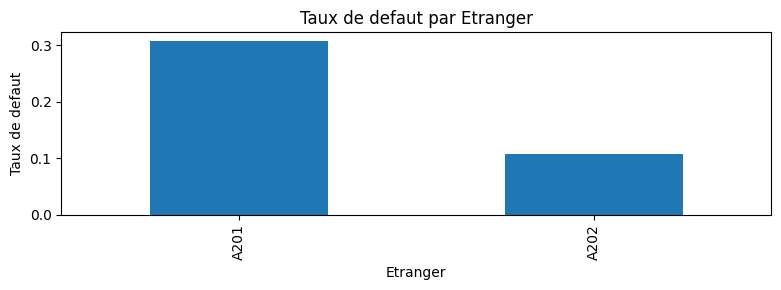

In [14]:
for col in categorical_cols:
    rates = df.groupby(col)[target_col].mean().sort_values(ascending=False)
    rates.plot(kind="bar", figsize=(8, 3), title=f"Taux de defaut par {col}")
    plt.ylabel("Taux de defaut")
    plt.tight_layout()
    plt.show()

## 8) Correlations (variables numeriques)

Pourquoi : detecter multicolinearite potentielle avant logit.


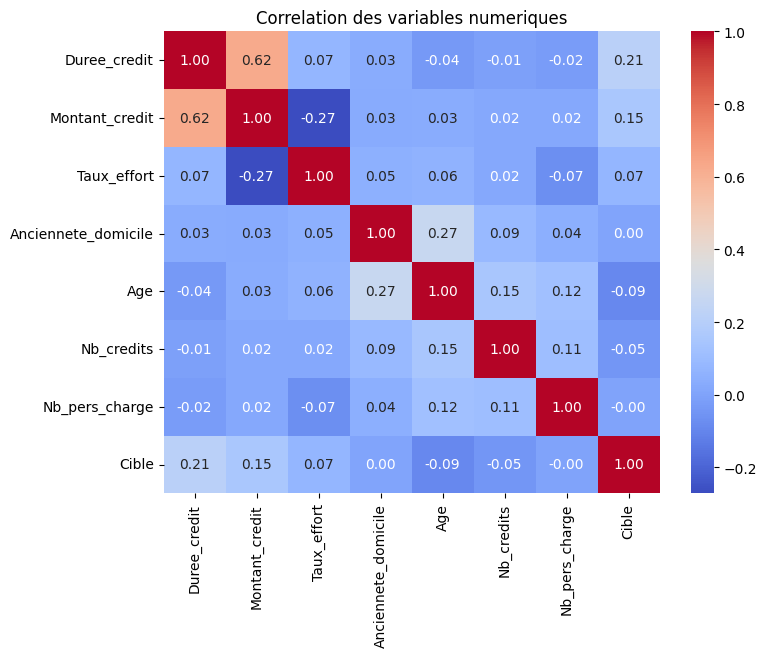

In [15]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation des variables numeriques")
plt.show()

## 9) Conclusions EDA (a completer)

- Resume des points cles (qualite data, desequilibre, variables dominantes)
- Impacts attendus sur la preparation et le choix des modeles


## 10) Diagnostics collinearite (pro)

VIF sur variables numeriques/ordinales et Cramer's V sur categories.


Note: VIF est pertinent sur variables numeriques/ordinales.
Pour les categories, on utilise Cramer's V car les dummies one-hot
creent des correlations structurelles (VIF gonfle).


In [16]:
vif_num = pd.read_csv('figures/tables/vif_numeric.csv')
vif_num.head(10)


,feature,vif
0,Montant_credit,2.013677
1,Duree_credit,1.866079
2,Taux_effort,1.238167
3,Age,1.162501
4,Anciennete_emploi,1.143462
5,Anciennete_domicile,1.119620
6,Nb_credits,1.042513
7,Nb_pers_charge,1.035946
8,Epargne,1.014034


In [17]:
cv_long = pd.read_csv('figures/tables/cramers_v_long.csv')
cv_long.head(10)


,var_1,var_2,cramers_v
0,Biens,Statut_domicile,0.553181
1,Type_emploi,Telephone,0.425694
2,Objet_credit,Telephone,0.220624
3,Historique_credit,Autres_credits,0.215368
4,Objet_credit,Statut_domicile,0.210169
5,Objet_credit,Biens,0.205818
6,Objet_credit,Type_emploi,0.202844
7,Situation_familiale,Statut_domicile,0.202165
8,Biens,Telephone,0.197805
9,Biens,Type_emploi,0.193905


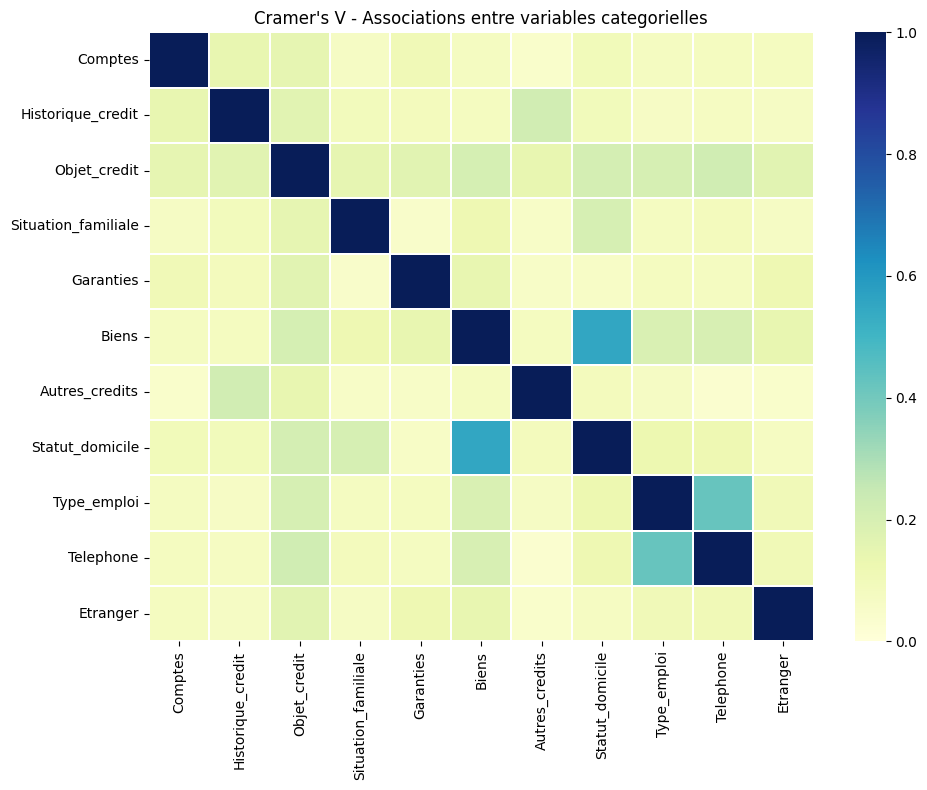

In [18]:
cramers_v = pd.read_csv('figures/tables/cramers_v_matrix.csv', index_col=0)
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v, cmap='YlGnBu', vmin=0, vmax=1, linewidths=0.2)
plt.title("Cramer's V - Associations entre variables categorielles")
plt.tight_layout()
plt.show()
